In [18]:
import pandas as pd
import numpy as np
import ppscore as pps
import plotly.express as px
import seaborn as sns

In [21]:
# read in dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape

(891, 12)

In [27]:
# survived is dependent variable
var = train.columns
target = 'Survived'
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
389,390,1,2,"Lehmann, Miss. Bertha",female,17.0,0,0,SC 1748,12.0000,NaN,C
640,641,0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
773,774,0,3,"Elias, Mr. Dibo",male,NaN,0,0,2674,7.2250,NaN,C
472,473,1,2,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33.0,1,2,C.A. 34651,27.7500,NaN,S
79,80,1,3,"Dowdell, Miss. Elizabeth",female,30.0,0,0,364516,12.4750,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
638,639,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,S
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C


In [28]:
var.

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
print(f"Survival rate of {round(train.Survived.sum() / train.Survived.count(),3) * 100} %")

Survival rate of 38.4 %


### Classify variables

- Categorical variables: Survived, Sex, Cabin, Embarked
- Ordinal variables: Pclass
- Continuous variables: Age, Fare
- Discrete variables: SibSp, Parch

In [4]:
# check to see how many values are missing
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- many cabin selections are missing, ages are also missing and a few embarked values are missing

In [32]:
# explore some of the missing variables
ppscores = pps.matrix(train)
ppscores
# sns.heatmap(pps.matrix(train

/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/data_science/lib/python3.9/site-packages/sklearn/model_selecti

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,PassengerId,PassengerId,1.000000,predict_itself,True,None,0.000000,1.000000,None
1,PassengerId,Survived,0.000000,regression,True,mean absolute error,0.383838,0.456813,DecisionTreeRegressor()
2,PassengerId,Pclass,0.000000,regression,True,mean absolute error,0.691358,0.928120,DecisionTreeRegressor()
3,PassengerId,Name,0.000000,target_is_id,True,None,0.000000,0.000000,None
4,PassengerId,Sex,0.000000,classification,True,weighted F1,0.557800,0.541261,DecisionTreeClassifier()
...,...,...,...,...,...,...,...,...,...
139,Embarked,Parch,0.000000,regression,True,mean absolute error,0.382452,0.578130,DecisionTreeRegressor()
140,Embarked,Ticket,0.000000,classification,True,weighted F1,0.001125,0.001095,DecisionTreeClassifier()
141,Embarked,Fare,0.000000,regression,True,mean absolute error,23.415106,26.258610,DecisionTreeRegressor()
142,Embarked,Cabin,0.010433,classification,True,weighted F1,0.000769,0.011194,DecisionTreeClassifier()


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'PassengerId'),
  Text(1.5, 0, 'Survived'),
  Text(2.5, 0, 'Pclass'),
  Text(3.5, 0, 'Age'),
  Text(4.5, 0, 'SibSp'),
  Text(5.5, 0, 'Parch'),
  Text(6.5, 0, 'Fare')])

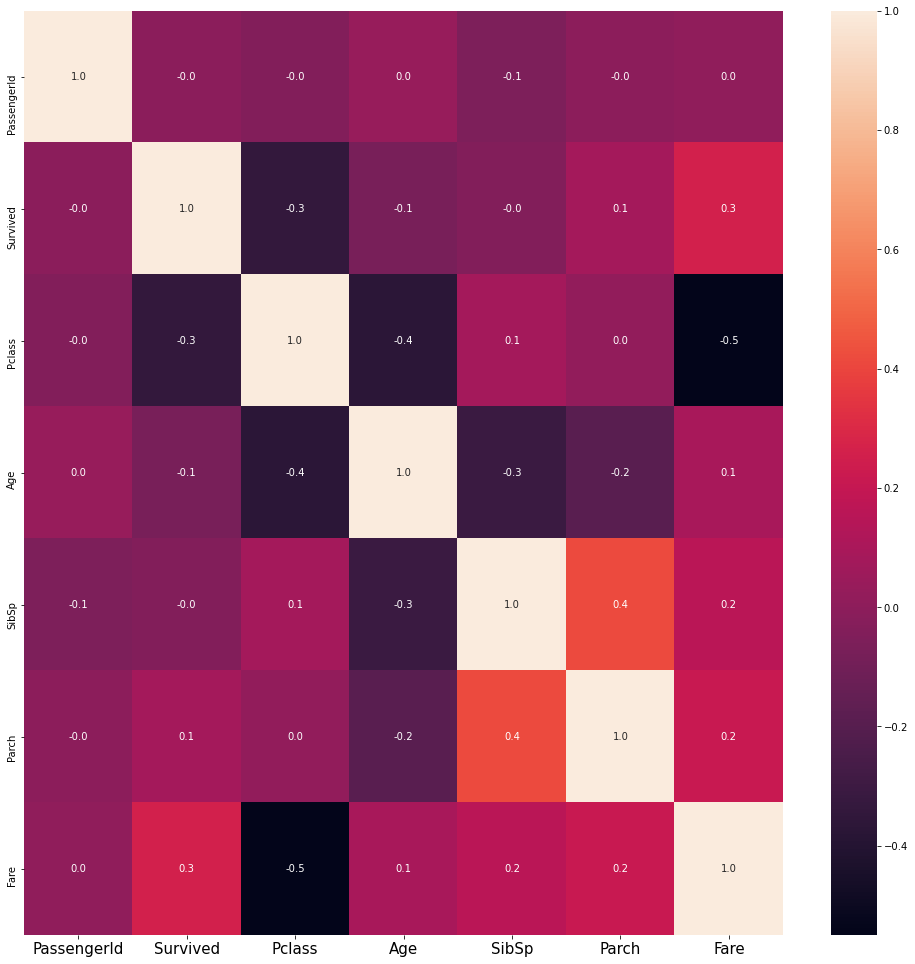

In [7]:
# examine correlations among the dataset
plt.figure(figsize = (17,17))

sns.heatmap(train.corr(), annot = True, fmt = '.1f')
plt.xticks(fontsize = 15)

In [63]:
# # lets explore the distribution of each variable
# fig, ax = plt.subplots(nrows = 3, 
#                        ncols = 2)
# for i in train.columns:
#     sns.distplot(train[i])

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

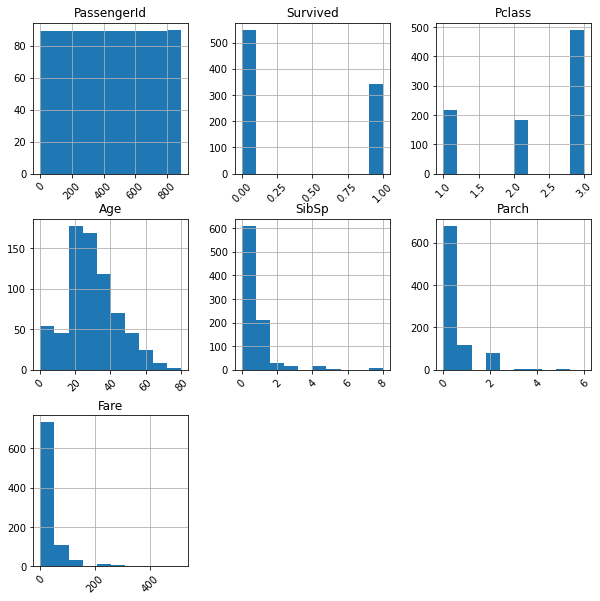

In [8]:
train.hist(figsize = (10,10),
          xrot = 45)

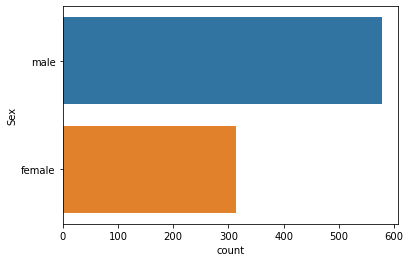

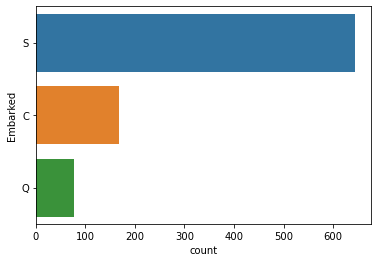

In [9]:
for column in train.select_dtypes(include='object'):
    if train[column].nunique() < 10:
        sns.countplot(y=column, data=train)
        plt.show()

Observations for features
- it might be worthwhile to convert ages into ordinal variables
- it could be interesting to add up sibling values